In [1]:
from langchain import OpenAI
from langchain.agents import Tool, tool
from langchain import agents
import langchain
import os
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import sys
import dziner


# from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
Embedding_model = 'text-embedding-3-large' 

from langchain.text_splitter import CharacterTextSplitter

In [2]:
## This model based on this paper: https://pubs.acs.org/doi/10.1021/acs.jcim.1c01334
## And is coming from this URL 
## https://github.com/dockstring/dockstring/tree/main
## Also see https://github.com/dockstring/dockstring/blob/main/dockstring/target.py#L160

from dockstring import load_target

@tool
def predict_docking_score(smiles):
    '''
    This tool predicts the docking score to DRD2 for a SMILES molecule. Lower docking score means a larger binding affinity.
    This model based on Autodock Vina from this paper: https://pubs.acs.org/doi/10.1021/acs.jcim.1c01334 
    '''
    target = load_target("DRD2")
    try:
        score, affinities = target.dock(smiles)
    except:
        score = 'Invalid molecule'
    return score

# score = predict_docking_score("CC1=C(C(=O)N2CCCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C=CC(=C5)F")

In [3]:
from langchain.memory import ConversationBufferMemory

RetrievalQA_prompt = """What are the design guidelines for making a molecule have a larger binding afinity against DRD2 target? 
    This can be based on making changes to the functional groups or other changes to the molecule. Summarize your answer and cite paper
    by the title, DOI and the journal and year the document was published on."""

@tool
def lookup_papers(prompt):
    '''Useful for getting chemical intuition for the problem.
    This tool looks up design guidelines for molecules with higher binding afinity against DRD2 by looking through research papers.
    It also includes information on the paper citation or DOI.
    '''
    guide_lines = []
    for m in range(1):
        text_splitter = CharacterTextSplitter(
            chunk_size=500, chunk_overlap=20)
        paper_file =f'../data/papers/Binding/DRD2/{m}.pdf'
        pages = PyPDFLoader(paper_file).load_and_split()
        sliced_pages = text_splitter.split_documents(pages)
        faiss_vectorstore = FAISS.from_documents(sliced_pages, OpenAIEmbeddings(model=Embedding_model))
        
        llm=ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.1,
                        )
        g = dziner.RetrievalQABypassTokenLimit(faiss_vectorstore, RetrievalQA_prompt, llm)
        guide_lines.append(g)
        # break
    return " ".join(guide_lines)


# guidel_lines = lookup_papers("")
# guidel_lines

In [4]:
@tool
def check_validity(SMILES):
    '''This tool inputs SMILES string representations checks if it is a chemically feasible molecule.
    '''
    from rdkit import Chem
    from rdkit.Chem import Draw
    try:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            return "Invalid", SMILES
        return "Valid", SMILES
    except Exception as e:
        # return f"An error occurred: {str(e)}"
        return "Invalid", SMILES



In [15]:
import sys
from rdkit import Chem
from rdkit.Chem import FilterCatalog
import pandas as pd

def check_filters(smiles):
    # Initialize filter catalogs
    params = FilterCatalog.FilterCatalogParams()
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_A)
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_B)
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_C)
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.NIH)
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.ZINC)
    catalog = FilterCatalog.FilterCatalog(params)
    
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES"
    
    # Check for matches in all catalogs
    results = []
    if catalog.HasMatch(mol):
        entry = catalog.GetFirstMatch(mol)
        if entry:
            results.append({
                "description": entry.GetDescription(),
                "Scope": entry.GetProp('Scope'),
            })
            print(f"Warning: molecule failed filter: reason {entry.GetDescription()}", file=sys.stderr)
    
    return results

# Example usage
smiles = "O=C(C)Oc1ccccc1C(=O)O"  # Example SMILES string for aspirin
results = check_filters(smiles)

# Convert results to a DataFrame for easier viewing
df = pd.DataFrame(results)
if not df.empty:
    print(df)
else:
    print("No filters matched the given SMILES.")

df

# If you want to display the results in a more user-friendly format
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Filter Matches", dataframe=df)


    description                                              Scope
0  phenol_ester  unwanted functionality due to potential tox re...


,description,Scope
0,phenol_ester,unwanted functionality due to potential tox re...


In [30]:
smiles = "O=C(C)Oc1ccccc1C(=O)O"
mol = Chem.MolFromSmiles(smiles)

params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_A)
# params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_B)
# params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_C)
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.NIH)
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.ZINC)
catalog = FilterCatalog.FilterCatalog(params)
entry = catalog.GetFirstMatch(mol)

In [31]:
entry.GetDescription()

'phenol_ester'

In [5]:
tools = [lookup_papers, check_validity, predict_docking_score]

tool_names = [tool.name for tool in tools]  
tool_desc = [tool.description for tool in tools]

initial_molecule = "CC(=O)OC1=CC=CC=C1C(=O)O" # this is Asprin
Human_prompt = f"Make changes to {initial_molecule} so it will have a larger binding affinity against DRD2 target."

input_data = {
            "input": Human_prompt,
            "prompt": RetrievalQA_prompt,
            "tools": tools,
            "tool_names": tool_names,
            "tool_desc": tool_desc
        }

In [6]:
from dziner.agents import dZiner
agent = dZiner(tools, property="Binding affinity",
               model='gpt-4o', verbose=True, n_design_iterations=10, temp=0.1).agent

agent.get_prompts

<bound method Runnable.get_prompts of AgentExecutor(memory=ConversationBufferMemory(output_key='output', input_key='input', return_messages=True, memory_key='chat_history'), verbose=True, tags=['zero-shot-react-description'], agent=ZeroShotAgent(llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_desc'], template='You are a helpful Chemist AI assistant called dZiner. You are tasked to make changes to a molecule based on some design guidelines\n    and optimize the its Binding affinity.\n    Always use the tools to get chemical intuition learn about the design guidelines. If you don\'t know, do not make up answers.\n    Explain changes you make in details at each step but do not put redundant information.\n    \n\nlookup_papers: lookup_papers(prompt) - Useful for getting chemical intuition for the problem.\n    This tool looks up design guidelines for molecules with higher binding afinity against DRD2 by looking through research papers.\n    It a

In [8]:
# response = agent_executor.invoke({"input": f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else.\n\
#             "})

In [9]:
iteration_data = []
iteration = 0
cost = 0
from langchain_community.callbacks import get_openai_callback


for step in agent.iter(input_data):
    with get_openai_callback() as cb:
        if output := step.get("intermediate_step"):
            action, value = output[0]
            if action.tool == "predict_docking_score":
                docking_score = value
            if action.tool == "check_validity":
                chemical_feasibility, SMILES = value
                iteration_data.append({
                                        'iteration': iteration,
                                        'data': {
                                            'SMILES': SMILES,
                                            'Chemical Feasibility': chemical_feasibility,
                                            'Docking Score': docking_score,
                                        }
                                    })
                iteration += 1
                # break 
                # assert is_prime(int(value))
            # Ask user if they want to continue
            # _continue = input("Should the agent continue (Y/n)?:\n") or "Y"
            # if _continue.lower() != "y":
            #     break
    cost += cb.total_cost

print(f'Cost: ${cost}')



> Entering new AgentExecutor chain...
Thought: To begin, I need to look up design guidelines for molecules with higher binding affinity against the DRD2 target. This will help me understand the structural features that enhance binding affinity.

Action: lookup_papers
Action Input: Design guidelines for molecules with higher binding affinity against DRD2

Observation: To design a molecule with a larger binding affinity against the DRD2 target, consider the following guidelines based on structural modifications:

1. **Cyclic Amine**: Incorporate cyclic amines such as piperazine or homopiperazine, which form noncovalent bonds with Asp3.32 in the transmembrane domain 3 of DRD2. However, note that increasing the bulkiness of the diaza-cycloaliphatic system can decrease electrostatic interaction and thus reduce affinity.

2. **Aromatic Moiety**: Use aromatic moieties directly connected to the cyclic amine. Substitutions in these aromatic moieties can significantly affect DRD2 affinity and 

In [10]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)O\n',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -6.2}},
 {'iteration': 1,
  'data': {'SMILES': 'CC(=O)N1CCN(CC1)C1=CC=CC=C1C(=O)O\n',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -7.8}},
 {'iteration': 2,
  'data': {'SMILES': 'CC(=O)N1CCN(CC1)C1=CC=CC(OC)=C1C(=O)O\n',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -7.0}},
 {'iteration': 3,
  'data': {'SMILES': 'CC(=O)N1CCN(CC1)CCOC1=CC=CC=C1C(=O)O\n',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -8.2}},
 {'iteration': 4,
  'data': {'SMILES': 'CC(=O)N1CCN(CC1)CCOC1=CC=CC=C1C(=O)C2=CC=CC=C2\n',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -8.8}},
 {'iteration': 5,
  'data': {'SMILES': 'CC(=O)N1CCN(CC1)CCOC1=CC=CC=C1C(=O)C2=CC=CC=C2F\n',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -9.2}},
 {'iteration': 6,
  'data': {'SMILES': 'CC(=O)N1CCN(CC1)CCOCC1=CC=CC=C1C(=O)C2=CC=CC=C2F\n',
   'Chemical Feasibility': 'Va

In [11]:
import json
json_data = json.dumps(iteration_data, indent=4)
# Save the JSON data to a file
with open(f"../results/Binding/{iteration_data[0]['data']['SMILES']}_guided.json", "w") as json_file:
    json_file.write(json_data)

Text(0, 0.5, 'Docking Score')

<Figure size 2560x1920 with 0 Axes>

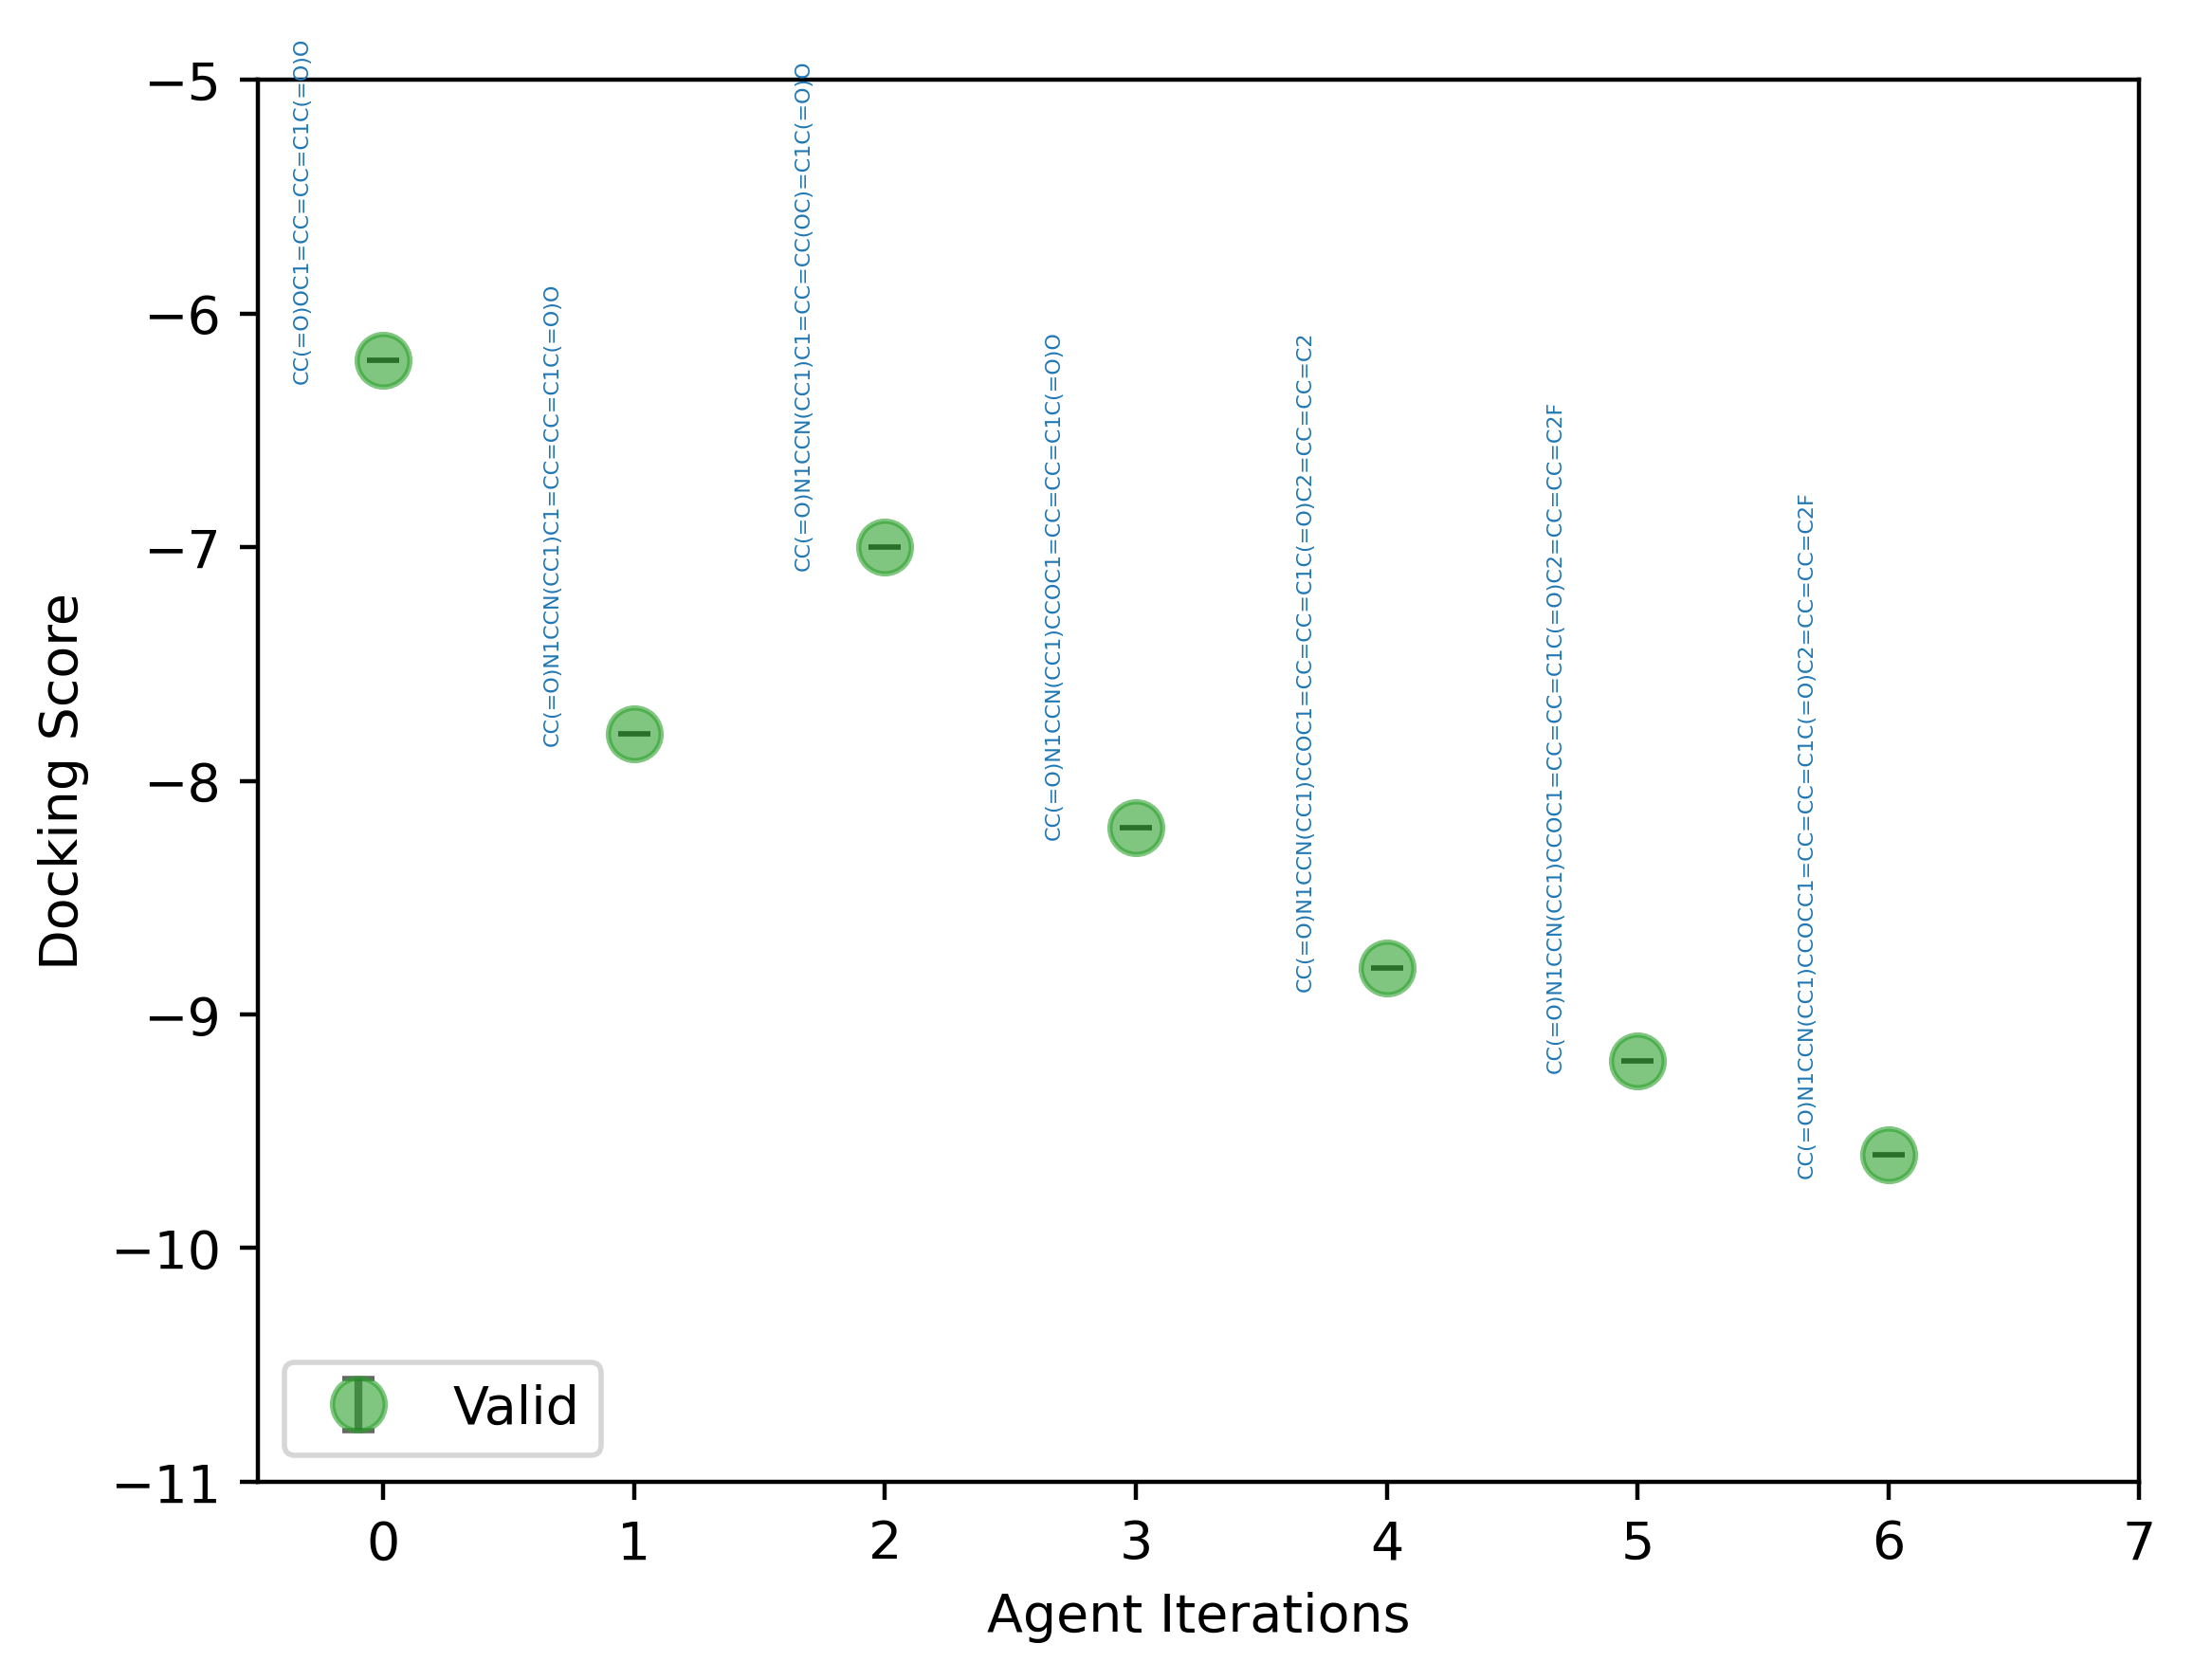

In [13]:
import matplotlib.pyplot as plt

iterations = [item['iteration'] for item in iteration_data]
mean_scores = [item['data']['Docking Score'] for item in iteration_data]
# std_band_gaps = [item['data']['STD CMC'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points
plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_scores, np.zeros(len(mean_scores)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])



vertical_offsets = [(-10 + 5 * (i % 2)) for i in range(len(iterations))]  # Alternating vertical offsets

for x, y, label, offset in zip(iterations, mean_scores, smiles_labels, vertical_offsets):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=4, color='C0', rotation=90)

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,7])
plt.ylim([-11, -5])
plt.ylabel('Docking Score')

# plt.savefig(f"../results/{iteration_data[0]['data']['SMILES']}_guided.png")

<Figure size 2560x1920 with 0 Axes>

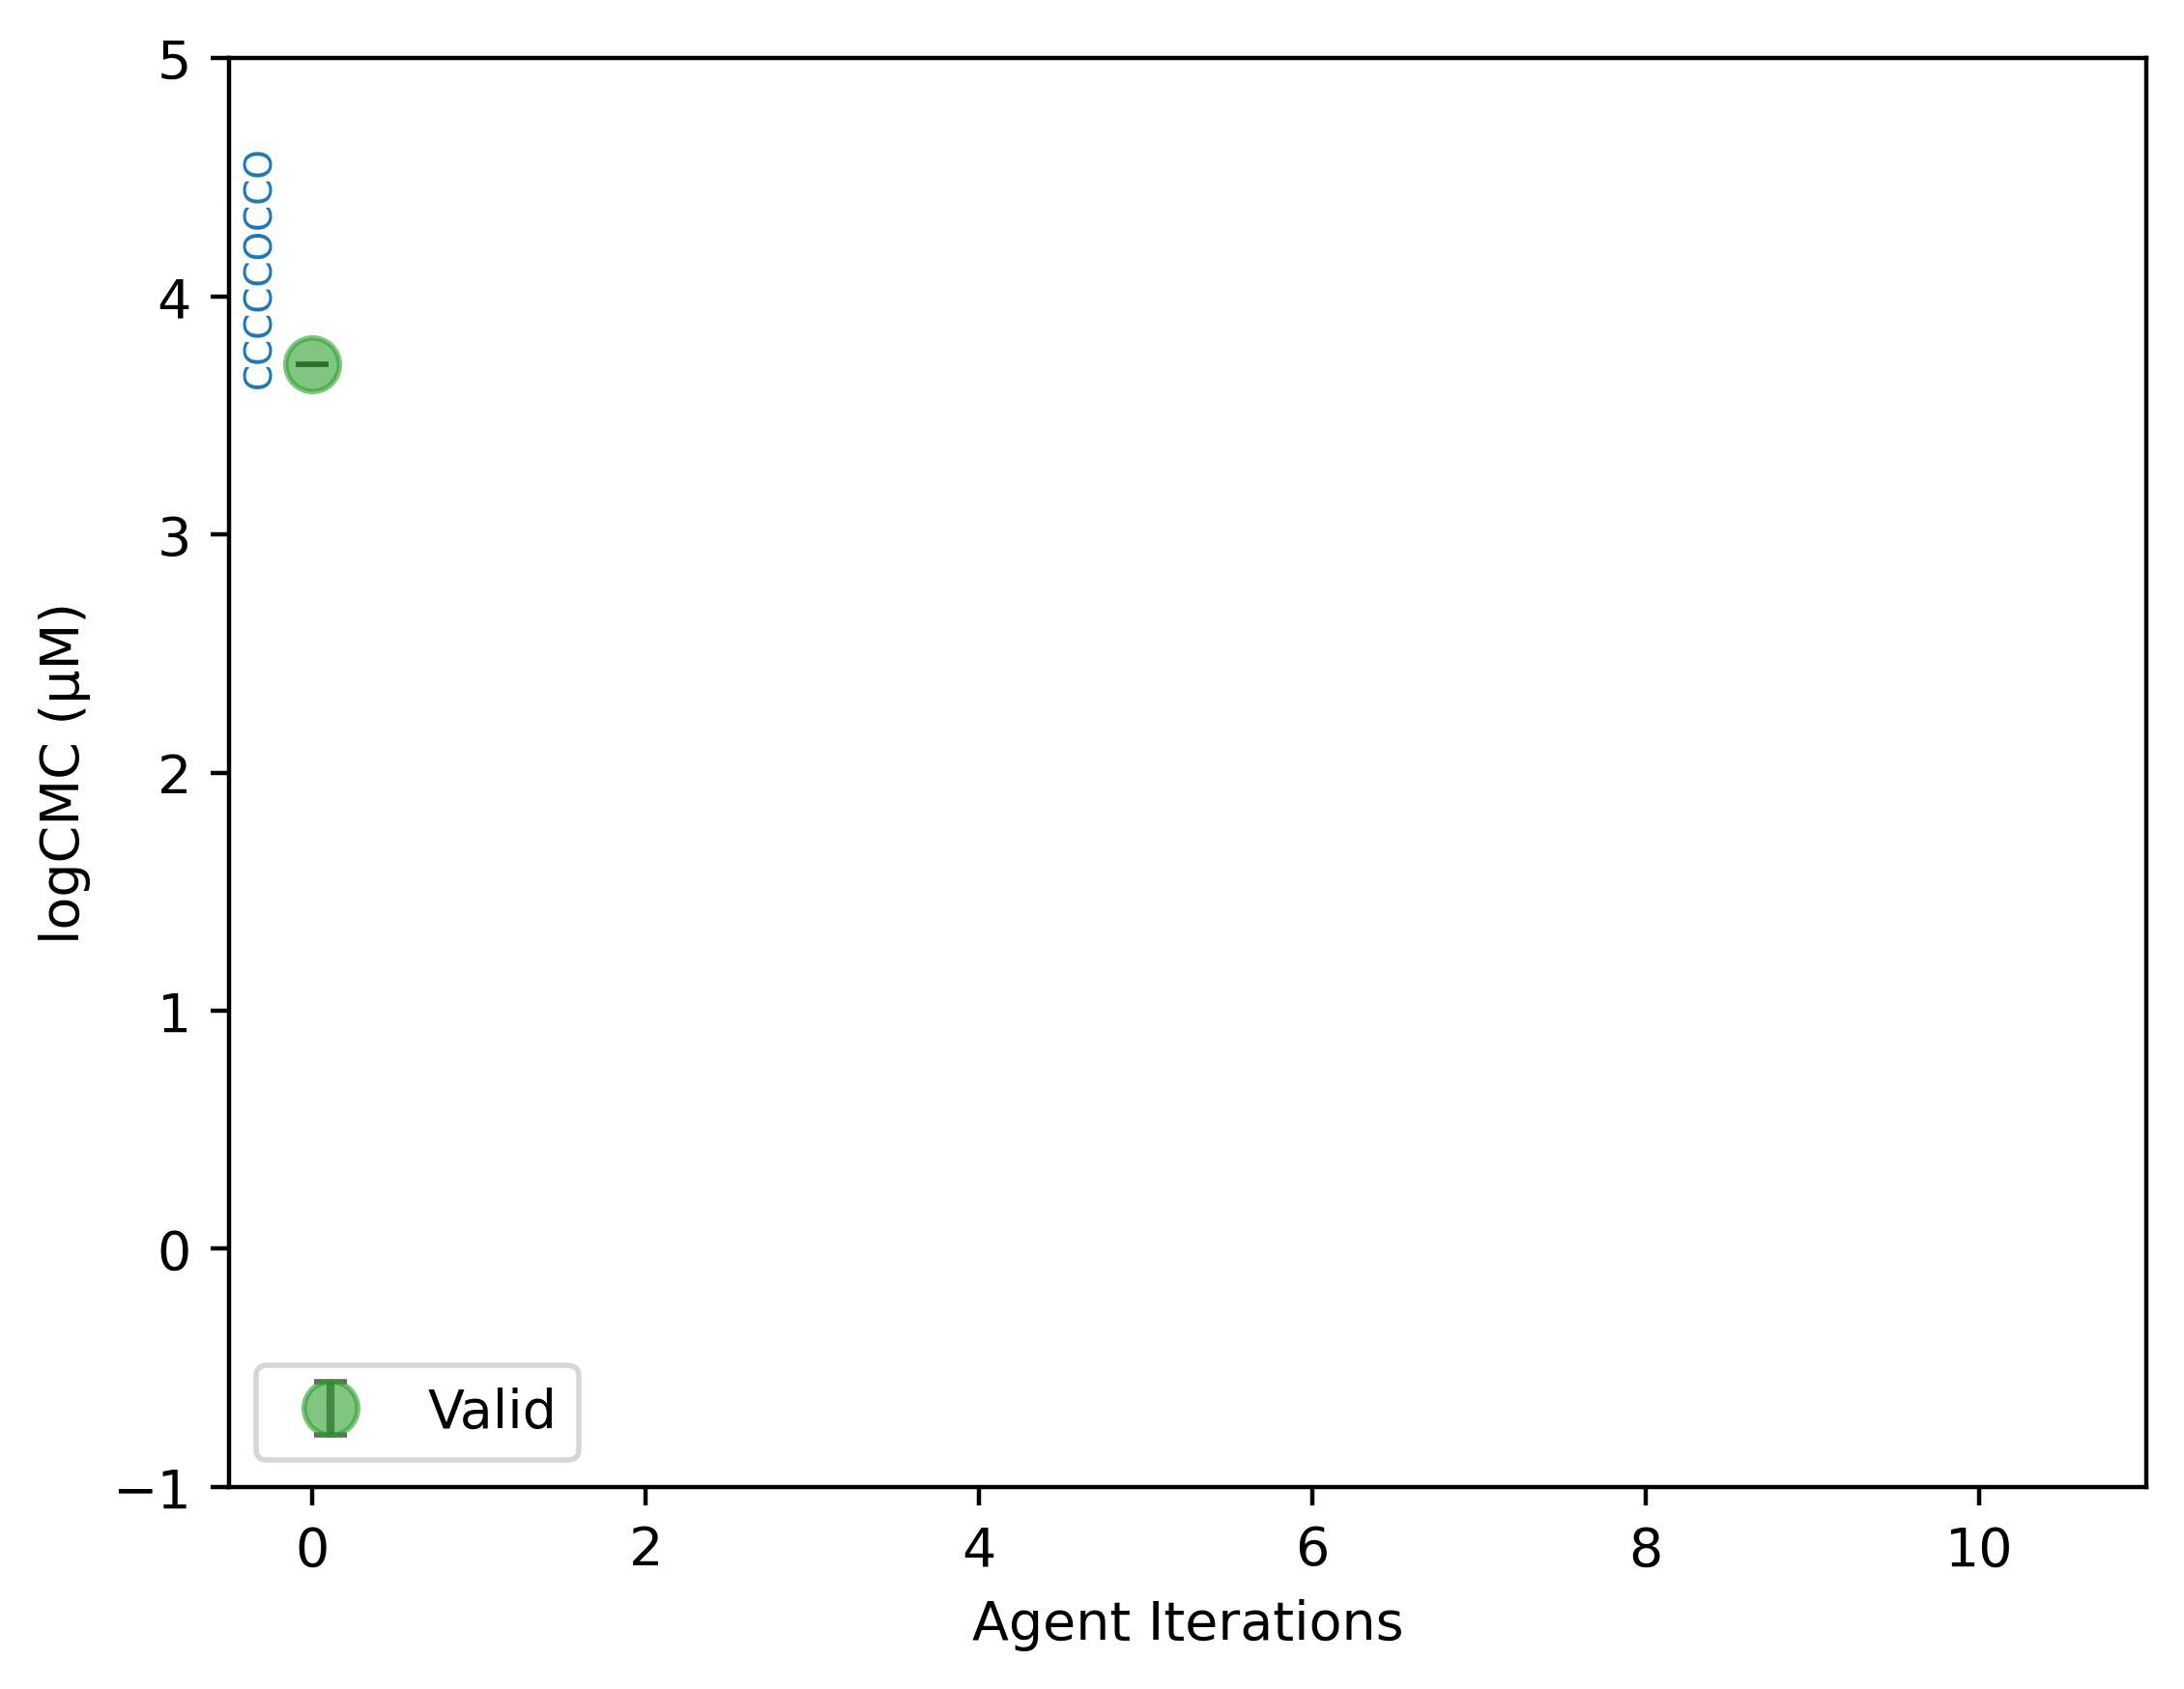

In [162]:
## Plotting sequntially for presentation purposes

# from rdkit import Chem
# from rdkit.Chem import Draw
# import matplotlib.pyplot as plt



# from rdkit.Chem import Draw
# from PIL import Image

# def visualize_smiles(smiles, filename):
#     # Convert SMILES to molecule
#     mol = Chem.MolFromSmiles(smiles)
    
#     # Generate image of the molecule with RDKit and a transparent background
#     img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
#     # Convert the image to have a transparent background
#     img = img.convert("RGBA")
#     datas = img.getdata()
#     newData = []
#     for item in datas:
#         # Change all white (also shades of whites)
#         # to transparent
#         if item[0] > 200 and item[1] > 200 and item[2] > 200:
#             newData.append((255, 255, 255, 0))
#         else:
#             newData.append(item)
#     img.putdata(newData)
    
#     # Save the image
#     img.save(filename, "PNG")


# import json


# with open(f"../results/CMC/{initial_surfactant}_guided.json", "r") as json_file:
#     iteration_data = json.load(json_file)

# iterations = [item['iteration'] for item in iteration_data]
# mean_cmcs = [item['data']['CMC'] for item in iteration_data]
# std_cmcs = np.zeros(len(mean_cmcs))
# smiles_labels = [item['data']['SMILES'] for item in iteration_data]
# chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

# plt.figure(dpi=400)

# colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# # Plot with error bars and color-coded points

# iter = 0

# plt.figure(dpi=400)
# for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
#     plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
#                  linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])

#     filename = f'../results/CMC/iter_{i}_{smiles_labels[i]}.png'
#     visualize_smiles(smiles_labels[i], filename)
#     if i == iter:
#         break


# vertical_offsets = [(-10 + 5 * (k % 2)) for k in range(len(iterations))]  # Alternating vertical offsets

# for i, (x, y, label, offset) in enumerate(zip(iterations, mean_cmcs, smiles_labels, vertical_offsets)):
#     plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)
#     if i == iter:
#         break

# ax=plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))

# plt.legend(by_label.values(), by_label.keys(), loc="lower left")

# plt.xlabel('Agent Iterations')
# plt.xlim([-0.5,11])
# plt.ylim([-1, 5])
# plt.ylabel('logCMC (μM)')

# plt.savefig(f"../results/CMC/{iter}_{smiles_labels[iter]}_guided.png")

In [125]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# import matplotlib.pyplot as plt



# from rdkit.Chem import Draw
# from PIL import Image

# def visualize_smiles(smiles, filename):
#     # Convert SMILES to molecule
#     mol = Chem.MolFromSmiles(smiles)
    
#     # Generate image of the molecule with RDKit and a transparent background
#     img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
#     # Convert the image to have a transparent background
#     img = img.convert("RGBA")
#     datas = img.getdata()
#     newData = []
#     for item in datas:
#         # Change all white (also shades of whites)
#         # to transparent
#         if item[0] > 200 and item[1] > 200 and item[2] > 200:
#             newData.append((255, 255, 255, 0))
#         else:
#             newData.append(item)
#     img.putdata(newData)
    
#     # Save the image
#     img.save(filename, "PNG")

# # Example usage
# filename = f'{initial_surfactant}.png'
# visualize_smiles(initial_surfactant, filename)

In [13]:
# results = agent.invoke(input=f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else. Do 5 iterations.\n\
#             ")